In [1]:
pip install seaborn

Looking in indexes: http://192.168.2.228:8888/repository/pypi/simple
DEPRECATION: moxing-framework 2.1.16.2ae09d45 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of moxing-framework or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 步骤一：导入相关库
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import zipfile

In [3]:
# 步骤二：加载数据集
zipfile_path = './airplane.zip'  # 压缩文件的路径
output_path = './'  # 解压后的输出目录
with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)
# 2.1 设置数据路径和图像尺寸
data_dir = "airplane"
image_size = (64, 64)
os.makedirs('./output', exist_ok=True)

# 2.2 定义读取图像文件夹的函数
def load_image_folder(path):
    X = []
    y = []
    class_names = sorted(os.listdir(path))
    for label, cls in enumerate(class_names):
        cls_path = os.path.join(path, cls)
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(cls_path, fname)
                img = Image.open(img_path).convert('RGB')  # 请在此处编写代码：读取图像并转换为RGB
                img = img.resize(image_size)  # 请在此处编写代码：resize图像为统一尺寸
                img_array = np.array(img) / 255.0  # 请在此处编写代码：转为numpy并归一化
                img_array = img_array.flatten()  # 请在此处编写代码：转换为(3, H, W)再flatten为1D向量
                X.append(img_array)
                y.append(label)
    return np.array(X), np.array(y), class_names

# 2.3 加载训练集和测试集
X_train, y_train, classes = load_image_folder(os.path.join(data_dir, 'train'))
X_test, y_test, _ = load_image_folder(os.path.join(data_dir, 'test'))

# 2.4 对训练集和测试集进行标准化处理
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# 步骤三：SVM 模型的构建
# 3.1 使用 sklearn 中的 SVC 构建支持向量机模型
clf = SVC(
    C=1.0,                # 请填写惩罚系数C的值（例如1.0）；C越大越追求训练集准确率，C越小则更偏向泛化
    kernel='rbf',           # 请填写核函数类型（如'rbf'、'linear'、'poly'等），决定输入数据如何映射到高维空间
    gamma='scale',            # 请填写gamma参数（如'scale'或'auto'），控制高斯核宽度
    decision_function_shape='ovr',  # 请填写多分类策略（如'ovr'表示one-vs-rest）
    verbose=False           # 是否输出训练过程日志（True / False）
)

In [5]:
# 步骤四：模型训练
# 4.1 使用训练数据拟合 SVM 模型
clf.fit(X_train_scaled, y_train)  # 请在此处编写代码：使用clf.fit训练模型

SVC()

In [6]:
# 步骤五：模型评估
# 5.1 使用训练好的模型对测试数据进行预测
y_pred = clf.predict(X_test_scaled)  # 请在此处编写代码：使用clf.predict生成预测结果

# 5.2 计算测试集上的准确率
acc = accuracy_score(y_test, y_pred)  # 请在此处编写代码：计算accuracy
print('********On Test Data********')
print(f"Accuracy: {acc:.4f}")

# 5.3 计算混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)  # 请在此处编写代码：使用confusion_matrix生成混淆矩阵

********On Test Data********
Accuracy: 0.8000


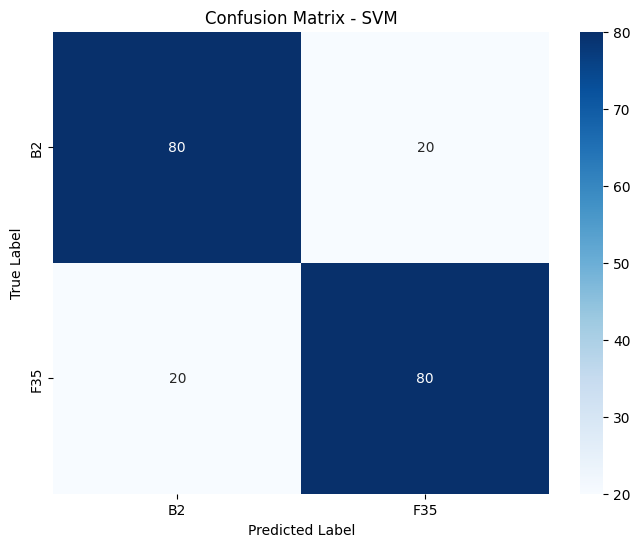

Number of support vectors for each class: [321 331]


In [7]:
# 步骤六：结果保存与可视化
# 6.1 绘制并保存混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.savefig('./output/sklearn_svm_confusion_matrix.png')
plt.show()

# 可选内容：输出支持向量数量
if hasattr(clf, 'n_support_'):
     print(f"Number of support vectors for each class: {clf.n_support_}")
elif hasattr(clf, 'support_vectors_'):
     print(f"Total number of support vectors: {clf.support_vectors_.shape[0]}")

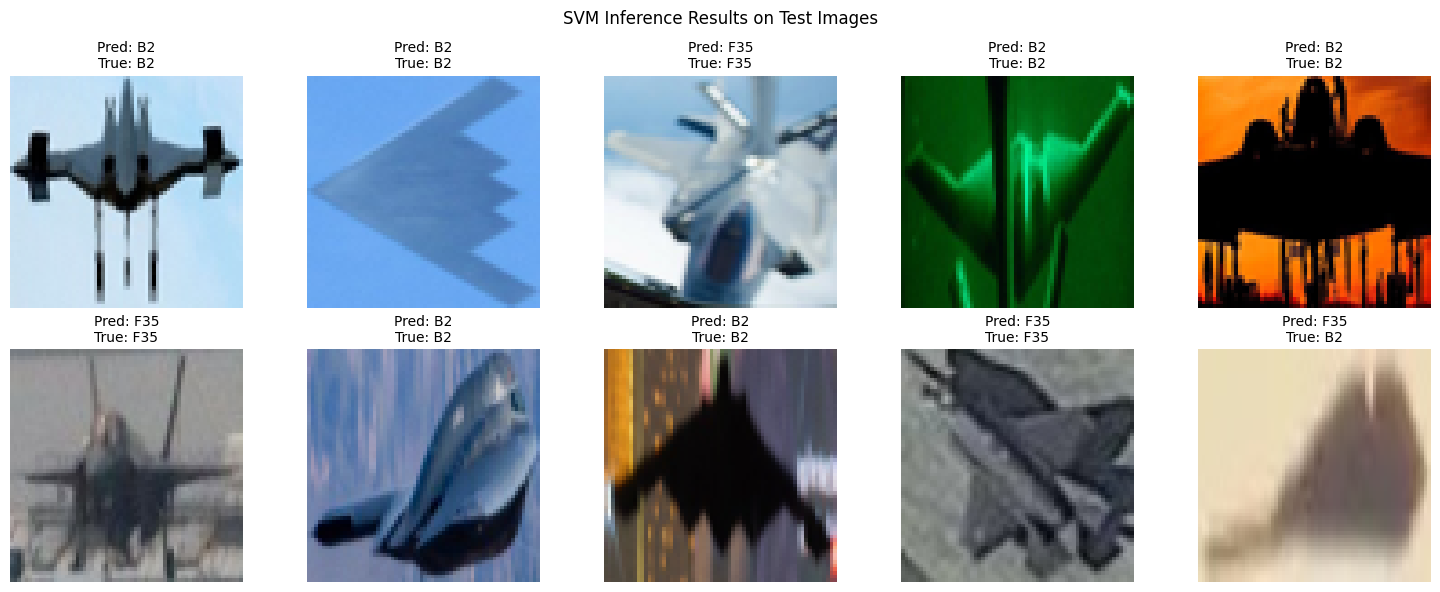

In [8]:
# 步骤七：推理结果可视化（展示若干张测试图像及预测结果）
def visualize_predictions(X_test_raw, X_test_processed, y_true, y_pred, class_names, num_images=10):
    indices = np.random.choice(len(X_test_raw), num_images, replace=False)
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        img_array = X_test_raw[idx]
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        
        # 获取图像的高度和宽度
        height, width = image_size

        # 还原图像：一维向量 -> (height, width, 3)
        img = img_array.reshape(height, width, 3)  # reshape为可显示图像格式
        img = np.clip(img, 0, 1)  # 请在此处编写代码：限制像素值在0-1范围（使用np.clip）

        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}", fontsize=10)
        plt.axis('off')

    plt.suptitle("SVM Inference Results on Test Images")
    plt.tight_layout()
    plt.savefig('./output/svm_test_predictions.png')
    plt.show()
    
visualize_predictions(
    X_test,
    X_test_scaled,
    y_test,
    y_pred,
    classes,
    num_images=10
)